In [29]:
!pip install h5py
!pip install tensorflow
!pip install matplotlib

In [30]:
import pandas as pd
import numpy as np
import h5py
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

In [31]:
from google.colab import drive
drive.mount("/content/gdrive")

# from google.colab import auth
# auth.authenticate_user()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [32]:
import os
os.chdir(r'/content/gdrive/MyDrive/University/LandslideProject')



### Testing the data

In [33]:
path_single = r"TrainData/img/image_1.h5"
path_single_mask = r"TrainData/mask/mask_1.h5"

ls ['img']
input data shape: (128, 128, 14)
data ndvi shape  (128, 128) f_data shape:  (1, 128, 128, 3)


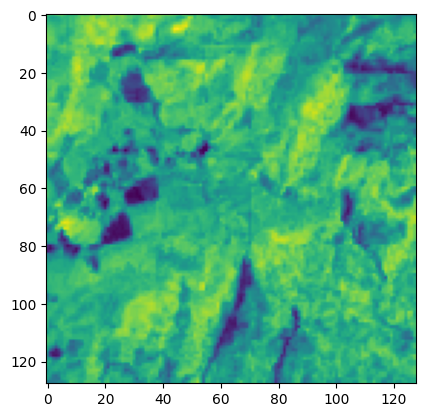

In [34]:
f_data = np.zeros((1, 128,128, 3))
with h5py.File(path_single) as hdf:
    ls = list(hdf.keys())
    print("ls", ls)
    data = np.array(hdf.get('img'))
    print("input data shape:", data.shape)
    plt.imshow(data[:, :, 3:0:-1])

    data_red = data[:, :, 3]
    data_green = data[:, :, 2]
    data_blue = data[:, :, 1]
    data_nir = data[:, :, 7]
    data_rgb = data[:, :, 3:0:-1]
    data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red))
    f_data[0, :, :, 0] =data_ndvi
    f_data[0, :, :, 1] = data[:, :, 12]
    f_data[0, :, :, 2] = data[:, :, 13]

    print("data ndvi shape ", data_ndvi.shape, "f_data shape: ", f_data.shape)
    plt.imshow(data_ndvi)

ls ['mask']
input data shape: (128, 128)


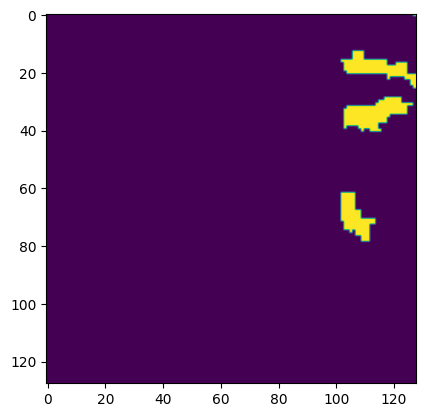

In [35]:
with h5py.File(path_single_mask) as hdf:
    ls = list(hdf.keys())
    print("ls", ls)
    data = np.array(hdf.get('mask'))
    print("input data shape:", data.shape)
    plt.imshow(data)

### Importing dataset from google drive folder

In [36]:
path_single = r"TrainData/img/image_10.h5"
path_single_mask = r'TrainData/mask/mask_1.h5'
TRAIN_PATH = r"TrainData/img/*.h5"
TRAIN_MASK = r'TrainData/mask/*.h5'

TRAIN_XX = np.zeros((10, 128, 128, 6))  #  TRAIN_XX = feature data and TRAIN_YY = output labels
TRAIN_YY = np.zeros((10, 128, 128, 1))   #TODO Change back to 3799 later after testing 10
all_train = sorted(glob.glob(TRAIN_PATH))

'''
Creates a sorted list of all .h5 file paths in the TrainData/img/ directory,
which will be used to iterate over to process each file in order.
'''

all_mask = sorted(glob.glob(TRAIN_MASK))

# Extracting data set from images and assigning to array

In [37]:
'''Scikit-learn's SVM modules needs 2D array as input data, and 1D as output label

For this, I'll 'flatten' each image with all its layers into a 2D numpy array. Each pixel's features across all
bands will form one row in the "feature matrix"

Take only the first 10 images and masks, because it
was too computationally expensive to do all 3800 images with an SVM'''
all_train = all_train[:10]
all_mask = all_mask[:10]


for i, (img, mask) in enumerate(zip(all_train, all_mask)):
    print(i, img, mask)
    #img for whole img dataset, mask for whole mask dataset
    #Each image in the dataset is its own hdf5 file
    with h5py.File(img) as hdf:
        ls = list(hdf.keys())
        #print(ls)

        data = np.array(hdf.get('img'))


        data[np.isnan(data)] = 0.000001


        mid_rgb = data[:, :, 1:4].max() / 2.0
        mid_slope = data[:, :, 12].max() / 2.0
        mid_elevation = data[:, :, 13].max() / 2.0


        data_red = data[:, :, 3]
        data_nir = data[:, :, 7]
        data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red))


        TRAIN_XX[i, :, :, 0] = 1 - data[:, :, 3] / mid_rgb  #RED
        TRAIN_XX[i, :, :, 1] = 1 - data[:, :, 2] / mid_rgb #GREEN
        TRAIN_XX[i, :, :, 2] = 1 - data[:, :, 1] / mid_rgb #BLUE
        TRAIN_XX[i, :, :, 3] = data_ndvi #NDVI
        TRAIN_XX[i, :, :, 4] = 1 - data[:, :, 12] / mid_slope #SLOPE
        TRAIN_XX[i, :, :, 5] = 1 - data[:, :, 13] / mid_elevation #ELEVATION

        #print(TRAIN_XX)
    with h5py.File(mask) as hdf:
        ls = list(hdf.keys())
        data=np.array(hdf.get('mask'))
        TRAIN_YY[i, :, :, 0] = data



0 TrainData/img/image_1.h5 TrainData/mask/mask_1.h5
1 TrainData/img/image_10.h5 TrainData/mask/mask_10.h5
2 TrainData/img/image_100.h5 TrainData/mask/mask_100.h5
3 TrainData/img/image_1000.h5 TrainData/mask/mask_1000.h5
4 TrainData/img/image_1001.h5 TrainData/mask/mask_1001.h5
5 TrainData/img/image_1002.h5 TrainData/mask/mask_1002.h5
6 TrainData/img/image_1003.h5 TrainData/mask/mask_1003.h5
7 TrainData/img/image_1004.h5 TrainData/mask/mask_1004.h5
8 TrainData/img/image_1005.h5 TrainData/mask/mask_1005.h5
9 TrainData/img/image_1006.h5 TrainData/mask/mask_1006.h5


# Reshape array into 2D array, so you can plug into SVM

In [38]:
'''
Here we are flattening the data. We are turning X into 2D numpy arrays, and y into a 1D array'''

X = TRAIN_XX.reshape(-1, TRAIN_XX.shape[-1])
# I.e. to (num_pixels, num_features_per_pixel)


y = TRAIN_YY.reshape(-1)

# Now, X and y can be slapped into the SVM for training


# Split into train and test datasets

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


svm_classifier = SVC(kernel='rbf', C=1, gamma='auto') #Can adjust kernel and sensitivity hyperparameters
svm_classifier.fit(X_train, y_train)

y_pred = svm_classifier.predict(X_test)

print("F1 Score:", f1_score(y_test, y_pred, average='binary'))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


F1 Score: 0.7100591715976332

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.99      0.99     31325
         1.0       0.82      0.62      0.71      1443

    accuracy                           0.98     32768
   macro avg       0.90      0.81      0.85     32768
weighted avg       0.98      0.98      0.98     32768



# **Results summary**

**0.0** refers to the output label of "no landslide".
**1.0** refers to the output label of "landslide".

###**Precision**:
#### True positives / (False + True Positives)
I.e. how well it will not label a sample as poitive if it is negative.

###**Recall/Sensitivity**:
####True Positives / (True Positives+False Negatives)
I.e. How well it can find the positive samples


###**F1-Score**:
Weigted mean of precision and recall.
2x (Precision x Recall) / (Precision + Recall)

###**Support**:
The number of occurences of that class are present in the specified dataset. It's the of samples of the true response that lie in that class.
I.e. Here, 1443 means there were 1443 pixels in the testing dataset that were actually landslides.